# 👨‍🎤👨‍⚖ actor-critic for llvm-autophase task

## Problem description:

This task in based on [CompilerGym](https://compilergym.com/) environment which is designed to make compilers closer to ml optimizations. It allows ML researchers to interact with important compiler optimization problems in a language and vocabulary with which they are comfortable, and provides a toolkit for systems developers to expose new compiler tasks for ML research. 

We will focus on *llvm-autophase* task. 

<<description of *llvm-autophase* task>>
The llvm-ic-v0 environment exposes LLVM's optimizing passes as a set of actions that can be applied to a particular program. The goal of the agent is to select the sequence of optimizations that lead to the greatest reduction in instruction count in the program being compiled

Compilers frequently package individual transformations as “optimization passes” which are then applied in a sequential order. Usually this order is fixed (e.g. [real world example](https://github.com/llvm/llvm-project/blob/71a8e4e7d6b947c8b954ec0763ff7969b3879d7b/llvm/lib/Transforms/IPO/PassManagerBuilder.cpp#L517-L922)). The CompilerGym LLVM environment replaces that fixed order with a sequential decision process where any pass may be applied at any stage.

Questions from Albina:
- what is LLVM-IR?
- what is LLVM statement?
- what are LLVM optimization levels: -O3, and -Oz?

### Overview of llvm environment in CompilerGym

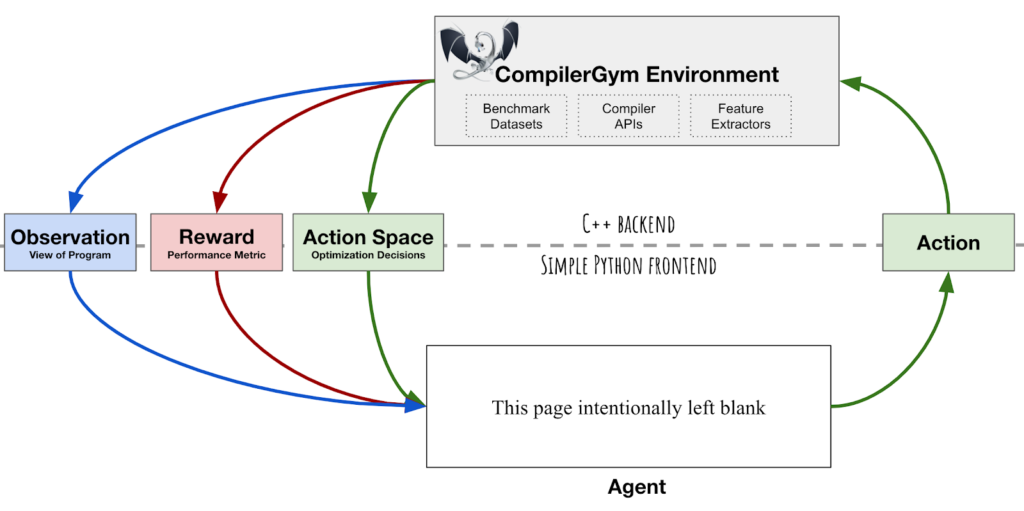

Here just some notes. For more go to [full overview](https://compilergym.com/llvm/index.html).

**Datasets.**

Load from model or add your own via `env.make_benchmark()` API.

**Observation Spaces.**

Here you can choose from a bunch of ways to record the "current state" of the compiler:


- LLVM-IR (Denis help, what it is???) `ir`
- [InstCount](https://compilergym.com/llvm/index.html#instcount) `ic`
    - 70-dimension integer feature vector in the range [0,∞]
    - the total number of instructions
    - the total number of basic blocks
    - the total number of functions
    - The remaining features are the number of instructions of each of the 67 different types in the program.
- [Autophase](https://compilergym.com/llvm/index.html#autophase) `autophase`
    - 56-dimension integer feature vector summarizing the static LLVM-IR representation
- [Inst2vec](https://compilergym.com/llvm/index.html#inst2vec)
    - represents LLVM-IR as sequence of embedding vectors
    - one vector = one LLVM statement (ex. `opaque = type opaque` or `ret i32 <%ID>`)
    - embeddings were trained offline on a large corpus of LLVM-IR 
    - shape of observation: (num_statements, 200)
- [ProGraML](https://compilergym.com/llvm/index.html#programl)
    - graph-based representation of LLVM-IR which includes `control-flow`, `data-flow`, and `call-flow`
- [Hardware Information](https://compilergym.com/llvm/index.html#hardware-information)
    - JSON dictionary, extracted using the cpuinfo library
    - example: `{'cores_count': 8, 'l1d_cache_count': 8, ...}`
- [Cost Models](https://compilergym.com/llvm/index.html#cost-models)
    - ??? don`t understand 
    - several variants of `IrInstructionCount` and `ObjectTextSize` 
- [Runtime](https://compilergym.com/llvm/index.html#runtime)
    - `isRunnable`, `Runtime`
    - only Experimental API!
- [Build Time](https://compilergym.com/llvm/index.html#build-time)
    - `isBuildable`, `Buildtime`
    - also only Experimental API!

[**Reward Spaces.**](https://compilergym.com/llvm/index.html#reward-spaces)

Reward is the value used to optimize our model at step. Reward navigates model to become better. In CompilerGym reward is constructured from `cost function`.
$$\text{reward} (\text{current\_step}) = \text{cost} (\text{prev\_step}) - \text{cost} (\text{current\_step})$$ 
You can select one of the following cost functions as your reward function:

- [IR Instruction Count](https://compilergym.com/llvm/index.html#ir-instruction-count)
    - The number of LLVM-IR instructions in the program can be used as a reward signal either using the raw change in instruction count (IrInstructionCount), or by scaling the changes in instruction count to the improvement made by the baseline -O3 or -Oz LLVM pipelines. 
    - fast to evaluate, deterministic, and platform-independent, but is not a measure of true codesize reduction as it does not take into account the effects of lowering.
- [Codesize](https://compilergym.com/llvm/index.html#codesize)
    - `ObjectTextSizeBytes` (the size of the `.TEXT` section of the module after lowering to an object file, before linking)
    - more expensive to compute than `IrInstructionCount`


[**Action Space.**](https://compilergym.com/llvm/index.html#action-space)

Actions in this environment are set of discrete transforms that can be applied.

For example:
- overall we have 124 otimizations in ... env (eg.: ...)
- 3 loop unrolling transfroms [LoopUnrollingEnv](https://github.com/facebookresearch/CompilerGym/tree/development/examples/example_unrolling_service) 
    - `-loop-unroll -unroll-count=2`
    - `-loop-unroll -unroll-count=4`
    - `-loop-unroll -unroll-count=8`
- we can limit action space like [here](https://github.com/ymahlau/ppo_compiler_gym/blob/72c08d86e4c96ed1e4579e5a00b9377e556609ab/llvm_wrapper.py)

**OVERALL.**

You can use one of preinstalled envs (with already selected action, observation and reward spaces) or prepare your own one.



TO ADD:
<!-- - passage about `env.close()` -->
- 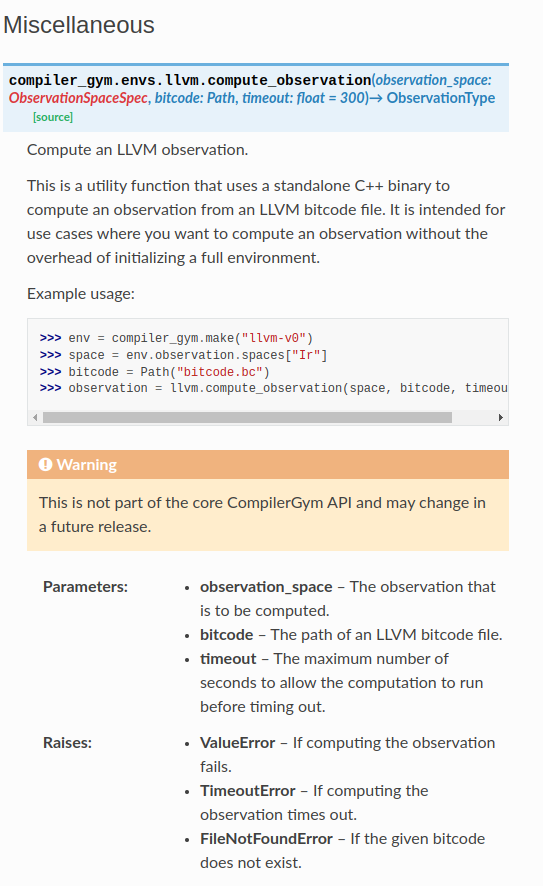
- разобраться с validate:
    - `python -m compiler_gym.bin.validate --env=llvm-ic-v0 results_temp.csv`
<!-- - Denis: how to switch between benchmarks in one training?
    - answer from [top1 of CommpilerGym Leaderboard](https://github.com/ymahlau/ppo_compiler_gym/blob/72c08d86e4c96ed1e4579e5a00b9377e556609ab/llvm_wrapper.py)
```
def switch_benchmark(self):
    idx = random.randint(0, -1 + len(self.benchmarks))
    print("Switched to {0}".format(self.benchmarks[idx]))
    self.env.close()
    self.env = gym.make("llvm-autophase-ic-v0", benchmark="cbench-v1/{0}".format(self.benchmarks[idx]))
``` -->

### Explore the environment

Let's start with the most common `llvm-ic-v0` env.

In [1]:
import compiler_gym

env = compiler_gym.make("llvm-ic-v0")
"""sample llvm env
    - no selected observation space
    - ic (instruction count) reward space
    - action space: 124 flags"""
    
env

Let's explore `env`, the environment, that we have just created. As you can remember there are 3 space which define the MDP (Markov Decision Process) on which we are going to work on, the are:

- Action space
- Reward space
- Observation space

But before it let's check the benchmark we are going to work with.

#### Benchmark

Check the default benchmark calling `env.benchmark`

In [2]:
env.benchmark

benchmark://cbench-v1/qsort

As you see, the default benchmark is `benchmark://cbench-v1/qsort`.

CompilerGym developers provide [a list](https://compilergym.com/llvm/index.html#datasets) of ready-to-use benchmarks from laters papers and an [API to load](https://compilergym.com/compiler_gym/envs.html#compiler_gym.envs.LlvmEnv.make_benchmark) your custrom benchmark.

Let's review some ready-to-use benchmarks:

In [3]:
for i, uri in enumerate(env.datasets.benchmark_uris()):
    print(uri)
    
    if i > 10:
        break

benchmark://cbench-v1/adpcm
benchmark://anghabench-v1/8cc/extr_buffer.c_buf_append
benchmark://blas-v0/1
benchmark://chstone-v0/adpcm
benchmark://clgen-v0/005ef03ac277e7418bb806ad623f5066de5031da
benchmark://github-v0/1
benchmark://jotaibench-v0/extr_anypixelfirmwarecontrollersrcfifo.c_FIFO_available_Final
benchmark://linux-v0/1
benchmark://mibench-v1/bitcount-1
benchmark://npb-v0/1
benchmark://opencv-v0/1
benchmark://poj104-v1/1/1001


Let's change the default benchmark to one of listed.

To do this we can use `env.reset()` method. This method is called at the beginning of each episode so we can jump between different benchmarks during the optimization or validation of our algorithm. And don't forget to call it before the first episode!

Note. If you feel uncomfortable with `env.reset()` and don't quite understand why do we need it, proceed to the following [link](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#reset).

In [4]:
benchmark = "benchmark://github-v0/1"
env.reset(benchmark=benchmark)

In [5]:
# env.datasets.benchmark(benchmark)  # TODO What is it and why we may need this?
# RE: Benchmarks are not normally instantiated directly. Instead, benchmarks are instantiated using env.datasets.benchmark(uri):

If you need to cycle throw several benchmarks you can use the following wrapper to your env: 

In [6]:
from compiler_gym.wrappers import CycleOverBenchmarks

env = CycleOverBenchmarks(
    env,
    benchmarks=[
        "benchmark://cbench-v1/crc32",
        "benchmark://cbench-v1/qsort",
        "benchmark://github-v0/1"
    ],
)

In [7]:
for i in range(10):
    print(env.benchmark)
    env.reset()

benchmark://github-v0/1
benchmark://cbench-v1/crc32
benchmark://cbench-v1/qsort
benchmark://github-v0/1
benchmark://cbench-v1/crc32
benchmark://cbench-v1/qsort
benchmark://github-v0/1
benchmark://cbench-v1/crc32
benchmark://cbench-v1/qsort
benchmark://github-v0/1


Our cycling over benchmarks loop works perfectly! 😍

Note. If you would like to randomly jump between benchmarks, you may use `RandomOrderBenchmarks` wrapper.

#### Action space

To review information about possible `gym.spaces` follow [the link](https://gymnasium.farama.org/api/spaces/#spaces). In CompilerGym common `gym.spaces` are extended with `compiler_gym.spaces` (here [the link](https://compilergym.com/compiler_gym/spaces.html#compiler-gym-spaces))

As you know, optimizations can be send to compiler as flags. Here we use the exact this opportunity to apply optimizations to compiler. \
Our action space is similar to `Discrete(124)`. (to recall what it means follow [this link](https://gymnasium.farama.org/api/spaces/fundamental/#discrete))

All possible actions are collected in alphabetical order to the variable of type `Commandline`. Further we will collect optimization passes (sequences of indexes of proposed optimization during each episode)

In [8]:
# Action space as sequence of flags in one `Commandline`
env.action_space

Commandline([-add-discriminators -adce -aggressive-instcombine -alignment-from-assumptions -always-inline -argpromotion -attributor -barrier -bdce -break-crit-edges -simplifycfg -callsite-splitting -called-value-propagation -canonicalize-aliases -consthoist -constmerge -constprop -coro-cleanup -coro-early -coro-elide -coro-split -correlated-propagation -cross-dso-cfi -deadargelim -dce -die -dse -reg2mem -div-rem-pairs -early-cse-memssa -early-cse -elim-avail-extern -ee-instrument -flattencfg -float2int -forceattrs -inline -insert-gcov-profiling -gvn-hoist -gvn -globaldce -globalopt -globalsplit -guard-widening -hotcoldsplit -ipconstprop -ipsccp -indvars -irce -infer-address-spaces -inferattrs -inject-tli-mappings -instsimplify -instcombine -instnamer -jump-threading -lcssa -licm -libcalls-shrinkwrap -load-store-vectorizer -loop-data-prefetch -loop-deletion -loop-distribute -loop-fusion -loop-guard-widening -loop-idiom -loop-instsimplify -loop-interchange -loop-load-elim -loop-predicati

In [9]:
env.action_space.n

124

In [10]:
# type of action_space
type(env.action_space)

compiler_gym.spaces.commandline.Commandline

In [11]:
# Action space as list of all available flags
env.action_space.flags  # or ``env.action_space.names`` and also ``env.action_space.descriptions``

['-add-discriminators',
 '-adce',
 '-aggressive-instcombine',
 '-alignment-from-assumptions',
 '-always-inline',
 '-argpromotion',
 '-attributor',
 '-barrier',
 '-bdce',
 '-break-crit-edges',
 '-simplifycfg',
 '-callsite-splitting',
 '-called-value-propagation',
 '-canonicalize-aliases',
 '-consthoist',
 '-constmerge',
 '-constprop',
 '-coro-cleanup',
 '-coro-early',
 '-coro-elide',
 '-coro-split',
 '-correlated-propagation',
 '-cross-dso-cfi',
 '-deadargelim',
 '-dce',
 '-die',
 '-dse',
 '-reg2mem',
 '-div-rem-pairs',
 '-early-cse-memssa',
 '-early-cse',
 '-elim-avail-extern',
 '-ee-instrument',
 '-flattencfg',
 '-float2int',
 '-forceattrs',
 '-inline',
 '-insert-gcov-profiling',
 '-gvn-hoist',
 '-gvn',
 '-globaldce',
 '-globalopt',
 '-globalsplit',
 '-guard-widening',
 '-hotcoldsplit',
 '-ipconstprop',
 '-ipsccp',
 '-indvars',
 '-irce',
 '-infer-address-spaces',
 '-inferattrs',
 '-inject-tli-mappings',
 '-instsimplify',
 '-instcombine',
 '-instnamer',
 '-jump-threading',
 '-lcssa',
 

In [12]:
# Random action (sample) which can be send to env.step() method
env.action_space.sample()

3

As you see, having a list of items, the cleanest way to encode the items is to use index of each item. Each number (int, from 0 to 124) represents one exact action from action space.

In [13]:
# If you need to encode command line params to numbers, you may you the following method
# Note: commandline should begin with `opt` and end with `input.bc -o output.bc`
env.commandline_to_actions('opt -consthoist -constmerge -mergereturn -coro-cleanup -argpromotion input.bc -o output.bc')

[14, 15, 123, 17, 5]

In [14]:
# And decode:
env.action_space.commandline([14, 15, 123, 17, 5])

'-consthoist -constmerge -mergereturn -coro-cleanup -argpromotion'

In [15]:
# Also during execution you may need to use this method. Let's check what it does.
help(env.commandline)

Help on method commandline in module compiler_gym.wrappers.core:

commandline() -> str method of compiler_gym.wrappers.datasets.CycleOverBenchmarks instance
    Interface for :class:`CompilerEnv <compiler_gym.envs.CompilerEnv>`
    subclasses to provide an equivalent commandline invocation to the
    current environment state.
    
    See also :meth:`commandline_to_actions()
    <compiler_gym.envs.CompilerEnv.commandline_to_actions>`.
    
    :return: A string commandline invocation.



As you see, this method showes command line of taken actions durung the current episode.

In [16]:
# No taken actions before `env.step()` method
env.commandline()

'opt  input.bc -o output.bc'

In [18]:
# Select some random number between 0 and 124
# chosen_action = ...
chosen_action = 13

print(f"The chosen action is {chosen_action}.")
print(f"The chosen action performs {env.action_space.flags[chosen_action]} optimization\n")

print(f"Preparing to step with action {chosen_action} ...\n")
observation, reward, done, info = env.step(chosen_action)
print(f"The action {chosen_action} resulted in:")
print(f"\t{observation=}\n\t{reward=}\n\t{done=}\n\t{info=}")

The chosen action is 13.
The chosen action performs -canonicalize-aliases optimization

Preparing to step with action 13 ...

The action 13 resulted in:
	observation=None
	reward=0.0
	done=False
	info={'action_had_no_effect': True, 'new_action_space': False}


In [19]:
# Command line after taking the step
env.commandline()

'opt -canonicalize-aliases input.bc -o output.bc'

We have just used method `env.step()` 🏅

If you feel uncomfortable with `env.step()` and don't quite understand why do we need it, proceed to the following [link](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#step)

One more thing we can do with action space is to limit action space to some smaller set of flags. Let's try it! Best way to do it is to use `compilter_gym.wrappers`

In [20]:
from compiler_gym.wrappers import ConstrainedCommandline

help(ConstrainedCommandline)

Help on class ConstrainedCommandline in module compiler_gym.wrappers.commandline:

class ConstrainedCommandline(compiler_gym.wrappers.core.ActionWrapper)
 |  ConstrainedCommandline(env: compiler_gym.envs.compiler_env.CompilerEnv, flags: Iterable[str], name: Optional[str] = None)
 |  
 |  Constrains a Commandline action space to a subset of the original space's
 |  flags.
 |  
 |  Method resolution order:
 |      ConstrainedCommandline
 |      compiler_gym.wrappers.core.ActionWrapper
 |      compiler_gym.wrappers.core.CompilerEnvWrapper
 |      compiler_gym.envs.compiler_env.CompilerEnv
 |      gym.core.Wrapper
 |      gym.core.Env
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env: compiler_gym.envs.compiler_env.CompilerEnv, flags: Iterable[str], name: Optional[str] = None)
 |      Constructor.
 |      
 |      :param env: The environment to wrap.
 |      
 |      :param flags: A list of entries from :code:`env.action_space.flags`
 |     

In [21]:
# Prepare the list of allowed actions
# allowed_actions = ... # add list of your besties opt flags (actions) here
allowed_actions = [
    '-barrier',
    '-bdce',
    '-break-crit-edges',
    '-simplifycfg',
    '-callsite-splitting',
    '-called-value-propagation',
    '-canonicalize-aliases',
    '-consthoist',
    '-constmerge',
]

# Wrap initial env to work only with limited action space
env = ConstrainedCommandline(env, flags=allowed_actions)

# Check new action space
assert env.action_space.n == len(allowed_actions)
env.action_space

Commandline([-barrier -bdce -break-crit-edges -simplifycfg -callsite-splitting -called-value-propagation -canonicalize-aliases -consthoist -constmerge])

The other wrapper to limit your action space is `TimeLimit`, which limits number of allowed steps in one episode. 

Let's leave only `5` actions. 

In [22]:
from compiler_gym.wrappers import TimeLimit

# max_episode_steps = ...
max_episode_steps = 5

env = TimeLimit(env, max_episode_steps=max_episode_steps)

In [27]:
# Reset environment at the beginning of the episode
env.reset()

for i in range(100):
    
    # Prepare some valid random action
    random_action = env.action_space.sample()

    # Step in the environment
    _, _, done, info = env.step(action = random_action)

    # Output some details
    print(f"{i=}\t {random_action=}\t {info=}")
    
    # Leave loop if env is terminated
    if done:
        print(f"Episode finished at {i=}")
        break

i=0	 random_action=3	 info={'action_had_no_effect': True, 'new_action_space': False}
i=1	 random_action=8	 info={'action_had_no_effect': True, 'new_action_space': False}
i=2	 random_action=2	 info={'action_had_no_effect': False, 'new_action_space': False}
i=3	 random_action=6	 info={'action_had_no_effect': True, 'new_action_space': False}
i=4	 random_action=3	 info={'action_had_no_effect': True, 'new_action_space': False, 'TimeLimit.truncated': True}
Episode finished at i=4


Now can customize `action_space` in `CompilerGym` as we like! 🗽

#### Reward space

Here we have 2 options: `IR Instruction Count` and `Codesize`

In [28]:
env.reward_space

IrInstructionCountOz

In [29]:
env.reward_range

(-inf, inf)

In [35]:
compiler_gym.COMPILER_GYM_ENVS

['gcc-v0',
 'llvm-v0',
 'llvm-ic-v0',
 'llvm-codesize-v0',
 'llvm-autophase-ic-v0',
 'llvm-autophase-codesize-v0',
 'llvm-ir-ic-v0',
 'llvm-ir-codesize-v0',
 'loop_tool-v0']

In [195]:
env.close()
env = compiler_gym.make("llvm-codesize-v0")  # previously we used 'llvm-ic-v0'
env.reset()

> Alternatively, an environment can be constructed directly, such as by connecting to a running compiler service at ``localhost:8080`` (see [this document](https://compilergym.com/compiler_gym/service.html) for more details):
>
>```python
>env = ClientServiceCompilerEnv(
>    service="localhost:8080",
>    observation_space="features",
>    reward_space="runtime",
>    rewards=[env_reward_spaces],
>)
>```

In [196]:
env.reward_space

ObjectTextSizeOz

We have changed the reward! 😃

In [197]:
# Try several times!
done = False
episode_reward = 0
print(f"Starting the episode ...")

while not done:
    _, reward, done, _ = env.step(action = env.action_space.sample())

    print(f"{reward=}")
    episode_reward += reward
    
    if done: #or reward > 100:
        print(f"Episode finished with {episode_reward=}")
        env.reset()
        break

Starting the episode ...
reward=0.0
reward=-112.0
reward=0.0
reward=0.0
reward=-48.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=-199.0
reward=0.0
reward=-248.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=-160.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=48.0
reward=-176.0
reward=0.0
reward=0.0
reward=491.0
reward=-144.0
reward=144.0
reward=0.0
reward=-463.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=-86.0
reward=-9851.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=-176.0
reward=0.0
reward=-1277.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=-274.0
reward=0.0
reward=

KeyboardInterrupt: 

You can see that after we have closed env and made new one all our wrappers vanished :(

By the way, in CompilerGym you shold always do NOT forget to close the environment. Read explanation [here](https://compilergym.com/faq.html#do-i-need-to-call-env-close). 

**Wrapping wrap up!**

So let's prepare transform function to fix new environment after creation! \
(this would help us to smothly fix new envs after creation)

In [198]:
def wrap_env(env):
    env = ... # add your code here
    return env

In [199]:
# expected solution
from compiler_gym.wrappers import CycleOverBenchmarks
from compiler_gym.wrappers import TimeLimit

def wrap_env(env):
    env = CycleOverBenchmarks(
        env,
        benchmarks=[
            "benchmark://cbench-v1/crc32",
            "benchmark://cbench-v1/qsort",
            "benchmark://github-v0/1"
        ],
    )
    env = TimeLimit(env, max_episode_steps=5)
    return env

In [200]:
env = wrap_env(env)

In [201]:
# some tests TODO (no ideas what to test)

#### Observation space

State of the compiler can be seen from `LLVM-IR`. Let's rewiev possible representations of `LLVM-IR`!
- [LLVM-IR](https://compilergym.com/llvm/index.html#llvm-ir)
- [InstCount](https://compilergym.com/llvm/index.html#instcount) 
- [Autophase](https://compilergym.com/llvm/index.html#autophase)
- [Inst2vec](https://compilergym.com/llvm/index.html#inst2vec)
- [ProGraML](https://compilergym.com/llvm/index.html#programl)
- [Hardware Information](https://compilergym.com/llvm/index.html#hardware-information)
- [Cost Models](https://compilergym.com/llvm/index.html#cost-models)
- [Runtime](https://compilergym.com/llvm/index.html#runtime)
- [Build Time](https://compilergym.com/llvm/index.html#build-time)

In [202]:
# list of all possible observations
env.observation.spaces

{'Ir': ObservationSpaceSpec(Ir),
 'IrSha1': ObservationSpaceSpec(IrSha1),
 'Bitcode': ObservationSpaceSpec(Bitcode),
 'BitcodeFile': ObservationSpaceSpec(BitcodeFile),
 'InstCount': ObservationSpaceSpec(InstCount),
 'Autophase': ObservationSpaceSpec(Autophase),
 'Programl': ObservationSpaceSpec(Programl),
 'ProgramlJson': ObservationSpaceSpec(ProgramlJson),
 'CpuInfo': ObservationSpaceSpec(CpuInfo),
 'IrInstructionCount': ObservationSpaceSpec(IrInstructionCount),
 'IrInstructionCountO0': ObservationSpaceSpec(IrInstructionCountO0),
 'IrInstructionCountO3': ObservationSpaceSpec(IrInstructionCountO3),
 'IrInstructionCountOz': ObservationSpaceSpec(IrInstructionCountOz),
 'ObjectTextSizeBytes': ObservationSpaceSpec(ObjectTextSizeBytes),
 'ObjectTextSizeO0': ObservationSpaceSpec(ObjectTextSizeO0),
 'ObjectTextSizeO3': ObservationSpaceSpec(ObjectTextSizeO3),
 'ObjectTextSizeOz': ObservationSpaceSpec(ObjectTextSizeOz),
 'TextSizeBytes': ObservationSpaceSpec(TextSizeBytes),
 'TextSizeO0': Obser

In [203]:
# Current state of the environment as it is (LLVM-IR)
print(env.ir)

; ModuleID = '-'
source_filename = "-"
target datalayout = "e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-unknown-linux-gnu"

%0 = type { i32, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, %1*, %0*, i32, i32, i64, i16, i8, [1 x i8], i8*, i64, %2*, %3*, %0*, i8*, i64, i32, [20 x i8] }
%1 = type opaque
%2 = type opaque
%3 = type opaque
%4 = type { i32, i32, i32, double }

@stderr = external dso_local global %0*, align 8
@0 = private unnamed_addr constant [27 x i8] c"Usage: qsort_large <file>\0A\00", align 1
@1 = private unnamed_addr constant [2 x i8] c"r\00", align 1
@2 = private unnamed_addr constant [3 x i8] c"%d\00", align 1
@3 = private unnamed_addr constant [57 x i8] c"\0ASorting %d vectors based on distance from the origin.\0A\0A\00", align 1
@4 = private unnamed_addr constant [18 x i8] c"sorted_output.dat\00", align 1
@5 = private unnamed_addr constant [3 x i8] c"wt\00", align 1
@6 = private unnamed_addr constant [32 x i8]

In [143]:
env.observation['IrSha1']

'deb9b5cf142f31c726fb391f5498351e81ce4095'

In [156]:
env.observation['Bitcode']

array([ 66,  67, -64, ...,   0,   0,   0], dtype=int8)

In [157]:
len(env.observation['Bitcode'])

39248

In [148]:
env.observation['BitcodeFile']

'/dev/shm/compiler_gym_cinemere/s/0118T191846-206110-93ac/module-582e8d25.bc'

In [149]:
!cat /dev/shm/compiler_gym_cinemere/s/0118T191846-206110-93ac/module-582e8d25.bc

E0118 19:31:48.310648530  141901 backup_poller.cc:134]       Run client channel backup poller: {"created":"@1705595508.310595153","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":320,"referenced_errors":[{"created":"@1705595508.310592500","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":950,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
BC��5     b0$JY�fM��OQ�L   !  %  !       �#�A�I29��%�b�EB�B�2K
*�F� ) I��9��D�0	 M*���dG�@I Q �F �`�D�B  ) �� �U�\e(�LF�" �L��� # h@�9P�#�2 0F Pb� �ERP�@ � `8��Q 
v@         0�*��          `H��  0     @ ��  `�d ��I  @   �� ��r�m�x�q`z0r�v@m0q x��!1d�H�@#��i��!F!   �   �� ���  �    0��HC$    @` ;$�3H    �� vH`;��=��8��;�C�C:�=�  ������0m`�����9�;�C9 �;�C�C=�<�=��8�C9�`���P �����0m`�����9�;�C9 �;�C�C:��;�9��>��

In [154]:
env.observation['InstCount']

array([4009,  582,   17,    5,  574,    0,    0,    0,    0,    3,    0,
          0,    0,    0,    0,  104,    2,   43,    0,   16,    3,    1,
          3,    0,    0,    0,    0,    5,    3,    0,   30,    1,    0,
          9,  629,  566,  863,    0,    0,    0,    4,   24,    4,    0,
          0,    0,    3,    0,    0,   34,   24,  246,    0,    0,    0,
        307,   40,  347,   77,   21,    0,    0,    0,   15,    3,    0,
          0,    0,    0,    0])

In [155]:
len(env.observation['InstCount'])

70

In [160]:
env.observation['Autophase']

array([  72,   78,  395,  150,  245,  223,  125,   51,   71,  351,   55,
        136,   14,  432,  150,  574,   21,  307,  925,  241,  767,  158,
        184,  223,  132,    0,  104,    9,   30,   32,  550,  246,  574,
         77,  863,  307,    3,  629,   16,    1,  347,    5,    4,   21,
          5,  566,   43,    4,    0,   24,  582, 4009, 2144,   17,  825,
        977])

In [161]:
len(env.observation['Autophase'])

56

In [163]:
env.observation['Programl']

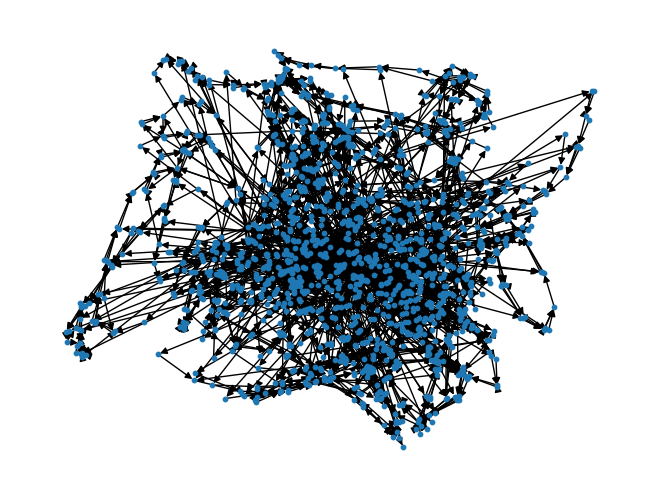

In [221]:
# Note. Slow cell :(
import networkx as nx

G = env.observation['Programl']
nx.draw(G, width=0.5, node_size=10)

In [167]:
env.observation['ProgramlJson']

{'directed': True,
 'graph': {'function': [{'module': 0, 'name': 'compare'},
   {'module': 0, 'name': 'llvm.lifetime.start.p0i8'},
   {'module': 0, 'name': 'llvm.lifetime.end.p0i8'},
   {'module': 0, 'name': 'main1'},
   {'module': 0, 'name': 'fprintf'},
   {'module': 0, 'name': 'exit'},
   {'module': 0, 'name': 'fopen'},
   {'module': 0, 'name': '__isoc99_fscanf'},
   {'module': 0, 'name': 'sqrt'},
   {'module': 0, 'name': 'fclose'},
   {'module': 0, 'name': 'printf'},
   {'module': 0, 'name': 'main'},
   {'module': 0, 'name': 'qsortx'},
   {'module': 0, 'name': 'fwrite'},
   {'module': 0, 'name': ''},
   {'module': 0, 'name': ''},
   {'module': 0, 'name': ''}],
  'module': [{'features': {'llvm_data_layout': ['e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128'],
     'llvm_target_triple': ['x86_64-unknown-linux-gnu']},
    'name': '-'}]},
 'links': [{'flow': 0, 'key': 0, 'position': 0, 'source': 1, 'target': 2},
  {'flow': 1, 'key': 0, 'position': 0, 'source': 3, 

In [168]:
env.observation['CpuInfo']

{'cores_count': 6,
 'l1d_cache_count': 6,
 'l1d_cache_size': 32768,
 'l1i_cache_count': 6,
 'l1i_cache_size': 32768,
 'l2_cache_count': 6,
 'l2_cache_size': 262144,
 'l3_cache_count': 1,
 'l3_cache_size': 12582912,
 'l4_cache_count': 0,
 'l4_cache_size': -1,
 'name': 'Intel Core i7-9750H'}

In [169]:
env.observation['IrInstructionCount']

4009

In [170]:
env.observation['IrInstructionCountO0']

638

In [171]:
env.observation['IrInstructionCountO3']

1163

In [172]:
env.observation['IrInstructionCountOz']

315

In [173]:
env.observation['ObjectTextSizeBytes']

38826

In [174]:
env.observation['ObjectTextSizeO0']

3113

In [175]:
env.observation['ObjectTextSizeO3']

8581

In [176]:
env.observation['ObjectTextSizeOz']

3798

In [177]:
env.observation['TextSizeBytes']

40446

In [178]:
env.observation['TextSizeO0']

4749

In [179]:
env.observation['TextSizeO3']

10177

In [180]:
env.observation['TextSizeOz']

5394

In [181]:
env.observation['IsBuildable']

True

In [182]:
env.observation['IsRunnable']

True

In [183]:
env.observation['Runtime']

array([0.029358])

In [184]:
env.observation['Buildtime']

array([0.076714])

In [185]:
env.observation['LexedIr']

{'token_id': array([ 63,   3, 400, ...,  14, 415,   9]),
 'token_category': array(['keyword', 'keyword', 'strval', ..., 'keyword', 'apsint',
        'keyword'], dtype=object),
 'token_value': array(['', '', '-', ..., '', '', ''], dtype=object),
 'token_kind': array(['kw_source_filename', 'equal', 'StringConstant', ..., 'exclaim',
        'APSInt', 'rbrace'], dtype=object)}

In [186]:
env.observation['Inst2vecPreprocessedText']

['opaque = type opaque',
 'opaque = type opaque',
 'opaque = type opaque',
 '<@ID> = external dso_local local_unnamed_addr global { i32, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, opaque*, <%ID>*, i32, i32, i64, i16, i8, [1 x i8], i8*, i64, opaque*, opaque*, <%ID>*, i8*, i64, i32, [20 x i8] }*, align 8',
 '<@ID> = private unnamed_addr constant [27 x i8]  <STRING>, align 1',
 '<@ID> = private unnamed_addr constant [2 x i8]  <STRING>, align 1',
 '<@ID> = private unnamed_addr constant [3 x i8]  <STRING>, align 1',
 '<@ID> = private unnamed_addr constant [57 x i8]  <STRING>, align 1',
 '<@ID> = private unnamed_addr constant [18 x i8]  <STRING>, align 1',
 '<@ID> = private unnamed_addr constant [3 x i8]  <STRING>, align 1',
 '<@ID> = private unnamed_addr constant [32 x i8]  <STRING>, align 1',
 '<@ID> = private unnamed_addr constant [10 x i8]  <STRING>, align 1',
 '<@ID> = private unnamed_addr constant [15 x i8]  <STRING>, align 1',
 '<@ID> = private unnamed_addr constant [3 x i

In [187]:
env.observation['Inst2vecEmbeddingIndices']

[8564,
 8564,
 8564,
 8564,
 39,
 5,
 40,
 64,
 35,
 40,
 11,
 19,
 46,
 40,
 13,
 8,
 8564,
 8564,
 8564,
 8564,
 864,
 523,
 1090,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 289,
 289,
 289,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 4763,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 198,
 204,
 8564,
 8564,
 198,
 204,
 8564,
 8564,
 198,
 8564,
 427,
 204,
 8564,
 8564,
 8564,
 8564,
 220,
 8564,
 8564,
 8564,
 8564,
 216,
 8564,
 8564,
 8564,
 8564,
 204,
 8564,
 8564,
 209,
 8564,
 209,
 630,
 204,
 8564,
 564,
 513,
 188,
 8564,
 8564,
 500,
 216,
 8564,
 443,
 363,
 363,
 567,
 567,
 193,
 1017,
 194,
 513,
 630,
 8564,
 8564,
 1291,
 204,
 8564,
 220,
 220,
 220,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,
 8564,

In [188]:
env.observation['Inst2vec']

array([[-0.59749085,  0.63315004, -0.0308373 , ...,  0.14833118,
         0.86420786,  0.44808227],
       [-0.59749085,  0.63315004, -0.0308373 , ...,  0.14833118,
         0.86420786,  0.44808227],
       [-0.59749085,  0.63315004, -0.0308373 , ...,  0.14833118,
         0.86420786,  0.44808227],
       ...,
       [-0.59749085,  0.63315004, -0.0308373 , ...,  0.14833118,
         0.86420786,  0.44808227],
       [-0.59749085,  0.63315004, -0.0308373 , ...,  0.14833118,
         0.86420786,  0.44808227],
       [-0.43074277,  0.8589559 , -0.35770646, ...,  0.28785184,
         0.8492773 ,  0.8914213 ]], dtype=float32)

In [189]:
env.observation['InstCountDict']

{'TotalInstsCount': 4009,
 'TotalBlocksCount': 582,
 'TotalFuncsCount': 17,
 'RetCount': 5,
 'BrCount': 574,
 'SwitchCount': 0,
 'IndirectBrCount': 0,
 'InvokeCount': 0,
 'ResumeCount': 0,
 'UnreachableCount': 3,
 'CleanupRetCount': 0,
 'CatchRetCount': 0,
 'CatchSwitchCount': 0,
 'CallBrCount': 0,
 'FNegCount': 0,
 'AddCount': 104,
 'FAddCount': 2,
 'SubCount': 43,
 'FSubCount': 0,
 'MulCount': 16,
 'FMulCount': 3,
 'UDivCount': 1,
 'SDivCount': 3,
 'FDivCount': 0,
 'URemCount': 0,
 'SRemCount': 0,
 'FRemCount': 0,
 'ShlCount': 5,
 'LShrCount': 3,
 'AShrCount': 0,
 'AndCount': 30,
 'OrCount': 1,
 'XorCount': 0,
 'AllocaCount': 9,
 'LoadCount': 629,
 'StoreCount': 566,
 'GetElementPtrCount': 863,
 'FenceCount': 0,
 'AtomicCmpXchgCount': 0,
 'AtomicRMWCount': 0,
 'TruncCount': 4,
 'ZExtCount': 24,
 'SExtCount': 4,
 'FPToUICount': 0,
 'FPToSICount': 0,
 'UIToFPCount': 0,
 'SIToFPCount': 3,
 'FPTruncCount': 0,
 'FPExtCount': 0,
 'PtrToIntCount': 34,
 'IntToPtrCount': 24,
 'BitCastCount': 

In [190]:
env.observation['InstCountNorm']

array([0.14517336, 0.00424046, 0.00124719, 0.14317785, 0.        ,
       0.        , 0.        , 0.        , 0.00074832, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02594163,
       0.00049888, 0.01072587, 0.        , 0.00399102, 0.00074832,
       0.00024944, 0.00074832, 0.        , 0.        , 0.        ,
       0.        , 0.00124719, 0.00074832, 0.        , 0.00748316,
       0.00024944, 0.        , 0.00224495, 0.15689698, 0.14118233,
       0.21526565, 0.        , 0.        , 0.        , 0.00099776,
       0.00598653, 0.00099776, 0.        , 0.        , 0.        ,
       0.00074832, 0.        , 0.        , 0.00848092, 0.00598653,
       0.06136193, 0.        , 0.        , 0.        , 0.0765777 ,
       0.00997755, 0.08655525, 0.01920678, 0.00523821, 0.        ,
       0.        , 0.        , 0.00374158, 0.00074832, 0.        ,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

In [191]:
env.observation['InstCountNormDict']

{'TotalBlocksDensity': 0.14517336,
 'TotalFuncsDensity': 0.004240459,
 'RetDensity': 0.0012471938,
 'BrDensity': 0.14317785,
 'SwitchDensity': 0.0,
 'IndirectBrDensity': 0.0,
 'InvokeDensity': 0.0,
 'ResumeDensity': 0.0,
 'UnreachableDensity': 0.0007483163,
 'CleanupRetDensity': 0.0,
 'CatchRetDensity': 0.0,
 'CatchSwitchDensity': 0.0,
 'CallBrDensity': 0.0,
 'FNegDensity': 0.0,
 'AddDensity': 0.02594163,
 'FAddDensity': 0.00049887755,
 'SubDensity': 0.010725867,
 'FSubDensity': 0.0,
 'MulDensity': 0.0039910204,
 'FMulDensity': 0.0007483163,
 'UDivDensity': 0.00024943877,
 'SDivDensity': 0.0007483163,
 'FDivDensity': 0.0,
 'URemDensity': 0.0,
 'SRemDensity': 0.0,
 'FRemDensity': 0.0,
 'ShlDensity': 0.0012471938,
 'LShrDensity': 0.0007483163,
 'AShrDensity': 0.0,
 'AndDensity': 0.007483163,
 'OrDensity': 0.00024943877,
 'XorDensity': 0.0,
 'AllocaDensity': 0.0022449489,
 'LoadDensity': 0.15689698,
 'StoreDensity': 0.14118233,
 'GetElementPtrDensity': 0.21526565,
 'FenceDensity': 0.0,
 '

In [192]:
env.observation['AutophaseDict']

{'BBNumArgsHi': 72,
 'BBNumArgsLo': 78,
 'onePred': 395,
 'onePredOneSuc': 150,
 'onePredTwoSuc': 245,
 'oneSuccessor': 223,
 'twoPred': 125,
 'twoPredOneSuc': 51,
 'twoEach': 71,
 'twoSuccessor': 351,
 'morePreds': 55,
 'BB03Phi': 136,
 'BBHiPhi': 14,
 'BBNoPhi': 432,
 'BeginPhi': 150,
 'BranchCount': 574,
 'returnInt': 21,
 'CriticalCount': 307,
 'NumEdges': 925,
 'const32Bit': 241,
 'const64Bit': 767,
 'numConstZeroes': 158,
 'numConstOnes': 184,
 'UncondBranches': 223,
 'binaryConstArg': 132,
 'NumAShrInst': 0,
 'NumAddInst': 104,
 'NumAllocaInst': 9,
 'NumAndInst': 30,
 'BlockMid': 32,
 'BlockLow': 550,
 'NumBitCastInst': 246,
 'NumBrInst': 574,
 'NumCallInst': 77,
 'NumGetElementPtrInst': 863,
 'NumICmpInst': 307,
 'NumLShrInst': 3,
 'NumLoadInst': 629,
 'NumMulInst': 16,
 'NumOrInst': 1,
 'NumPHIInst': 347,
 'NumRetInst': 5,
 'NumSExtInst': 4,
 'NumSelectInst': 21,
 'NumShlInst': 5,
 'NumStoreInst': 566,
 'NumSubInst': 43,
 'NumTruncInst': 4,
 'NumXorInst': 0,
 'NumZExtInst': 24

In [193]:
env.observation['LexedIrTuple']

[LexedToken(ID=63, kind='kw_source_filename', category='keyword', value=''),
 LexedToken(ID=3, kind='equal', category='keyword', value=''),
 LexedToken(ID=400, kind='StringConstant', category='strval', value='-'),
 LexedToken(ID=61, kind='kw_target', category='keyword', value=''),
 LexedToken(ID=66, kind='kw_datalayout', category='keyword', value=''),
 LexedToken(ID=3, kind='equal', category='keyword', value=''),
 LexedToken(ID=400, kind='StringConstant', category='strval', value='e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128'),
 LexedToken(ID=61, kind='kw_target', category='keyword', value=''),
 LexedToken(ID=62, kind='kw_triple', category='keyword', value=''),
 LexedToken(ID=3, kind='equal', category='keyword', value=''),
 LexedToken(ID=400, kind='StringConstant', category='strval', value='x86_64-unknown-linux-gnu'),
 LexedToken(ID=392, kind='LocalVarID', category='uintval', value=''),
 LexedToken(ID=3, kind='equal', category='keyword', value=''),
 LexedToken

So we have observed all possible varians of observations. 

Choose one of them for setup!

In [208]:
# Why do we need setup? Look:
env.reset()
observation, reward, done, info = env.step(9)

print(f"Current observation in {observation=}")

Current observation in observation=None


To fix this `None` we should setup observation.

**Variant 1.** Use already prepared env from ``compiler_gym.COMPILER_GYM_ENVS``


In [209]:
compiler_gym.COMPILER_GYM_ENVS

['gcc-v0',
 'llvm-v0',
 'llvm-ic-v0',
 'llvm-codesize-v0',
 'llvm-autophase-ic-v0',
 'llvm-autophase-codesize-v0',
 'llvm-ir-ic-v0',
 'llvm-ir-codesize-v0',
 'loop_tool-v0']

In [213]:
env.close()
env = compiler_gym.make("llvm-autophase-ic-v0")
observation = env.reset()
print(f"Initial observation is {observation}")

Initial observation is [  0   4  54  39  12  46  23   6  12  31   2   4   0  81   4  77  13  15
 108 106  75  51  71  46  15   0   9  46   0  13  72  51  77  81  39  31
   0 163   2   0   4   6  13   1   0  73   8   1   0  15  85 638 402  16
  10 298]


**Variant 2.** Be more descriptive in `compiler_gym.make(...)`

In [214]:
env.close()
env = compiler_gym.make(
    "llvm-v0",                              # selects the compiler to use
    benchmark="cbench-v1/qsort",            # selects the program to compile
    observation_space="Autophase",          # selects the observation space
    reward_space="IrInstructionCountOz",    # selects the reward space
)
observation = env.reset()
print(f"Initial observation is {observation}")

Initial observation is [  0   4  54  39  12  46  23   6  12  31   2   4   0  81   4  77  13  15
 108 106  75  51  71  46  15   0   9  46   0  13  72  51  77  81  39  31
   0 163   2   0   4   6  13   1   0  73   8   1   0  15  85 638 402  16
  10 298]


**Variant 3\***. If the ready-to-use list of observation is just not enough for you. Prepare your own observation wrapper

`compiler_gym.wrappers.ObservationWrapper`

In [215]:
help(compiler_gym.wrappers.ObservationWrapper)

Help on class ObservationWrapper in module compiler_gym.wrappers.core:

class ObservationWrapper(CompilerEnvWrapper, abc.ABC)
 |  ObservationWrapper(env: compiler_gym.envs.compiler_env.CompilerEnv)
 |  
 |  Wraps a :class:`CompilerEnv <compiler_gym.envs.CompilerEnv>` environment
 |  to allow an observation space transformation.
 |  
 |  Method resolution order:
 |      ObservationWrapper
 |      CompilerEnvWrapper
 |      compiler_gym.envs.compiler_env.CompilerEnv
 |      gym.core.Wrapper
 |      gym.core.Env
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  convert_observation(self, observation: ~ObservationType) -> ~ObservationType
 |      Translate an observation to the new space.
 |  
 |  multistep(self, actions: List[~ActionType], observation_spaces: Optional[Iterable[Union[str, compiler_gym.views.observation_space_spec.ObservationSpaceSpec]]] = None, reward_spaces: Optional[Iterable[Union[str, compiler_gym.spaces.reward.Reward]]] = None, observations